In [1]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset
dataset_url = 'kmhas_dataset.txt'
data = pd.read_csv(dataset_url, sep='\t')

In [4]:
# Merge labels
label_columns = ['출신차별', '외모차별', '정치성향차별', '혐오욕설', '연령차별', '성차별', '인종차별', '종교차별', '해당사항 없음']
data['multi_class_label'] = data[label_columns].idxmax(axis=1)

In [5]:
# Encode Label & Make label column
id2label = {k:v for k, v in enumerate(data['multi_class_label'].unique())}
label2id = {v:k for k, v in id2label.items()}

data['labels'] = data['multi_class_label'].map(label2id)

In [6]:
# Split and Make Dataset
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

In [7]:
# Tokenize Dataset
tokenizer = AutoTokenizer.from_pretrained('monologg/koelectra-base-v3-discriminator')
def tokenize_data(data):
    encoded = tokenizer(
        data['document'],
        truncation=True
    )
    encoded['labels'] = data['labels']
    return encoded

tokenized_train_dataset = train_dataset.map(tokenize_data, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_data, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_data, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/61.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

Map:   0%|          | 0/87753 [00:00<?, ? examples/s]

Map:   0%|          | 0/10969 [00:00<?, ? examples/s]

Map:   0%|          | 0/10970 [00:00<?, ? examples/s]

In [8]:
# Load Collator
collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest'    # pad to longest sequence in batch
)

In [9]:
# Function to compute metrics
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average='weighted')
    precision = precision_score(p.label_ids, preds, average='weighted')
    return {'accuracy': accuracy, 'f1': f1, 'precision': round(precision, 6)}


In [10]:
# Load arguments
training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        weight_decay=.01,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=3e-5,
        evaluation_strategy='steps',
        eval_steps=300,
        save_strategy='steps',
        save_steps=300,
        logging_strategy='steps',
        logging_steps=500,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
        greater_is_better=True,
        lr_scheduler_type='cosine',
        warmup_ratio=0.1

    )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
# Load & Train model

model = AutoModelForSequenceClassification.from_pretrained('monologg/koelectra-base-v3-discriminator', id2label=id2label, label2id=label2id)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=collator,
    compute_metrics=compute_metrics
)

trainer.train()

pytorch_model.bin:   0%|          | 0.00/452M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision
300,No log,1.587969,0.539247,0.377831,0.290787
600,1.741400,1.317323,0.584374,0.484221,0.414517
900,1.741400,1.188435,0.615644,0.563830,0.522063
1200,1.241300,1.119507,0.632783,0.579602,0.591337
1500,1.065200,0.902783,0.707539,0.668873,0.667879
1800,1.065200,0.747177,0.766250,0.750403,0.764536
2100,0.810500,0.679332,0.780837,0.781894,0.792882
2400,0.810500,0.638977,0.805452,0.799608,0.803587
2700,0.675500,0.592381,0.807549,0.805015,0.808136
3000,0.601800,0.596959,0.816847,0.811507,0.816042


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

TrainOutput(global_step=16455, training_loss=0.48928340052949804, metrics={'train_runtime': 6655.4314, 'train_samples_per_second': 39.556, 'train_steps_per_second': 2.472, 'total_flos': 8882033750939250.0, 'train_loss': 0.48928340052949804, 'epoch': 3.0})

In [15]:
# Evaluate the final model on the test set
test_results = trainer.evaluate(tokenized_test_dataset)

print(f"Test Accuracy: {test_results['eval_accuracy']}")
print(f"Test F1 Score: {test_results['eval_f1']}")
print(f"Test Precision: {test_results['eval_precision']}")

Test Accuracy: 0.8531449407474931
Test F1 Score: 0.8528567301300344
Test Precision: 0.853066


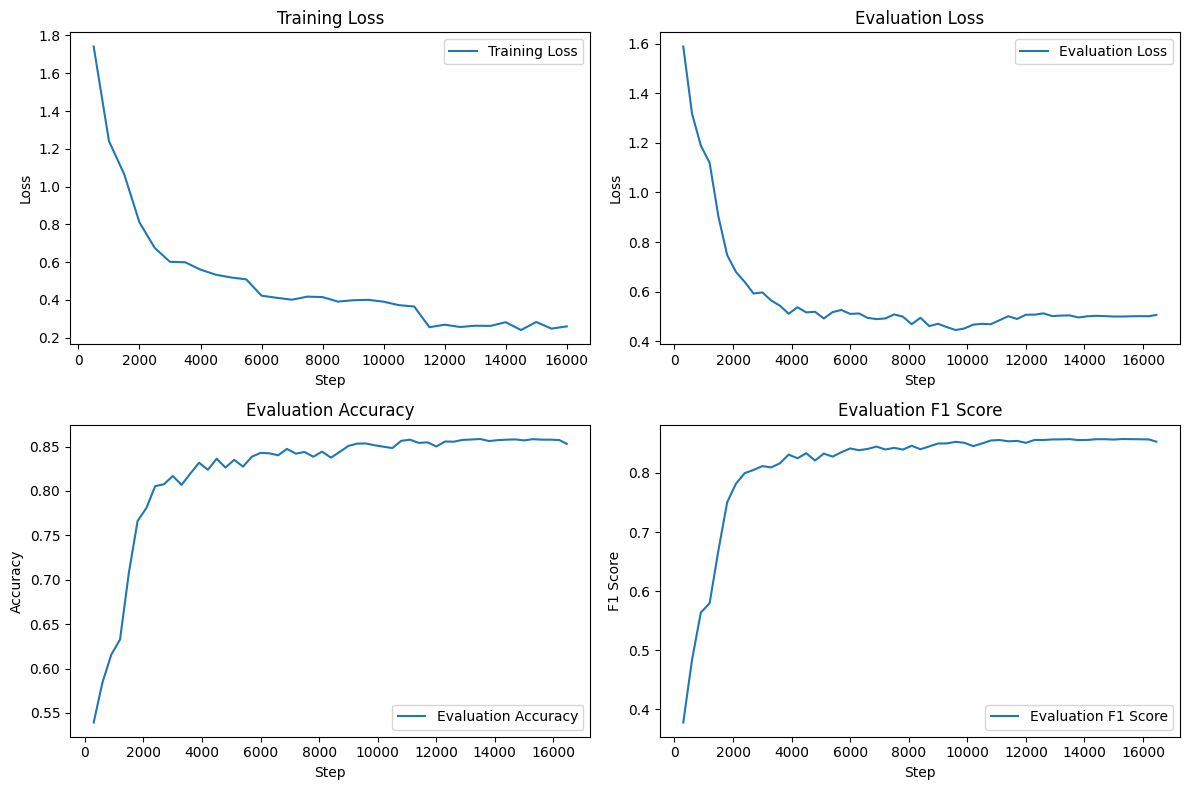

In [16]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Creating the plots
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(eval_steps, eval_accuracy, label='Evaluation Accuracy')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(eval_steps, eval_f1, label='Evaluation F1 Score')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('F1 Score')
plt.title('Evaluation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

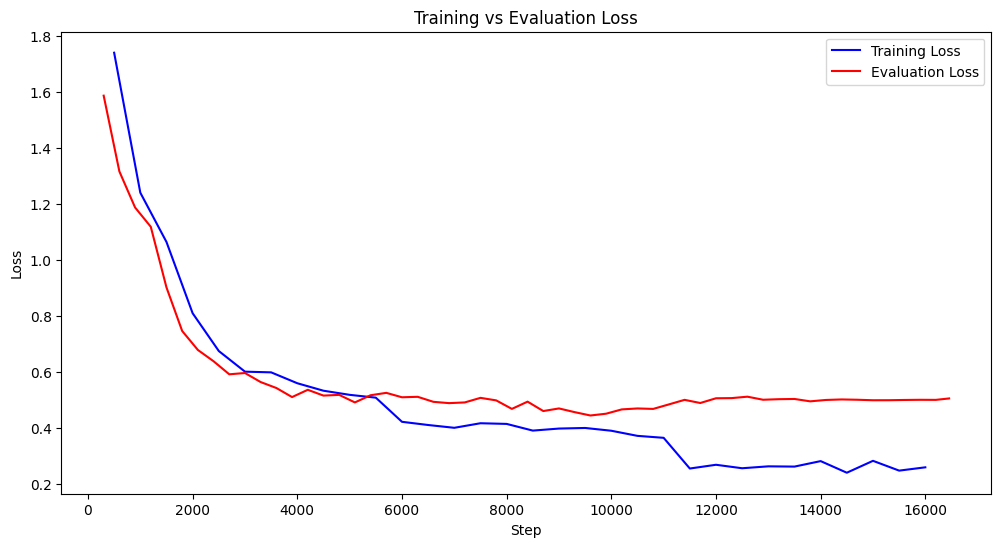

In [17]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Plotting Loss (Training and Evaluation on the same graph)
plt.figure(figsize=(12, 6))

plt.plot(train_steps, train_loss, label='Training Loss', color='blue')
plt.plot(eval_steps, eval_loss, label='Evaluation Loss', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()


In [18]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=3b944940c7c8b2c35a76002232cdc40a01032c7dd9d0679d093ae197f42a96af
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [19]:
from lime.lime_text import LimeTextExplainer
import numpy as np
import matplotlib.font_manager as fm
import torch
import re

In [20]:
# 모델을 GPU로 이동
model = model.to('cuda')

# predict_proba 함수 수정
def predict_proba(texts):
    # 텍스트를 리스트로 받아 한 번에 처리
    encoded_texts = tokenizer(texts, truncation=True, padding=True, return_tensors='pt', max_length=512)
    encoded_texts = {k: v.to('cuda') for k, v in encoded_texts.items()}
    with torch.no_grad():
        outputs = model(**encoded_texts)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return predictions.to('cpu').numpy()

# LIME 설명 생성기를 멀티 클래스 라벨에 맞게 초기화
class_names = ['출신차별', '외모차별', '정치성향차별', '혐오욕설', '연령차별', '성차별', '인종차별', '종교차별', '해당사항 없음']
explainer = LimeTextExplainer(class_names=class_names)


In [21]:
random_indices = np.random.choice(test_data.index, size=5, replace=False)
for idx in random_indices:
    sample_text = test_data.loc[idx]['document']
    # LIME을 사용하여 예측 설명 생성
    exp = explainer.explain_instance(sample_text, predict_proba, num_features=6,labels=range(len(class_names)))
    # 설명 출력 (텍스트로 출력)
    print(f"Explanation for index {idx}:")
    for label in exp.available_labels():
        print(f"Label {class_names[label]}:")
        for feature, weight in exp.as_list(label=label):
            print(f"  {feature}: {weight}")


Explanation for index 31581:
Label 출신차별:
  찐년들이: -0.00376202918073041
  뒤룩뒤룩: -0.0022398410856157036
  메퇘지년들아: 0.0019286300432053928
  뇌에: 0.0017697555245293627
  살: -0.0016789509645033424
  그만냅둬: -0.0013892595438074577
Label 외모차별:
  찐년들이: -0.23606384295406493
  메퇘지년들아: -0.20439199373260195
  얘좀: -0.0595631487462896
  살: -0.0564148803495248
  뒤룩뒤룩: -0.03814411205075223
  ㅉㅉ: -0.03324708410795696
Label 정치성향차별:
  뒤룩뒤룩: -0.00027033540288677355
  무슨: 0.00015424069713760046
  메퇘지년들아: -0.00011250781803955947
  찐년들이: -0.0001029741353011766
  그만냅둬: -8.831245913672329e-05
  ㅉㅉ: 7.255439597468946e-05
Label 혐오욕설:
  살: -0.3823440428959281
  뒤룩뒤룩: -0.27410439477853915
  찐년들이: 0.09895529547130152
  ㅉㅉ: 0.07481265058736435
  사고를: 0.06871667328014273
  메퇘지년들아: 0.039377221039337336
Label 연령차별:
  찐년들이: -0.004748948413615532
  뒤룩뒤룩: -0.0042691187175062095
  메퇘지년들아: 0.0036719334454578755
  살: -0.0030266845951607423
  뇌에: 0.001767029042686567
  얘좀: -0.0017602721706714282
Label 성차별:
  살: 0.4429444603829131


In [22]:
# Save the explanation to an HTML file
exp.save_to_file('kmhas_lime_explanation.html')